# Fruit Classification

Classification of 100 Fruit classes: [Data Retrieved from Kaggle](https://www.kaggle.com/datasets/marquis03/fruits-100)

## Model of Choice

EfficientNetB2
* 9.1M parameters
* ~95% Accuracy

This implies the size of the model, can possibly fit onto the mobile device with better inference speed.

## Goal of Model Performance

Performance Metrics:
* Accuracy: ~95%
* Prediction latency: ~30ms (30FPS)

In [62]:
from torch import nn
import torch
import torchvision

from torchvision import datasets
from torch.utils.data import DataLoader, random_split

from torchinfo import summary

import matplotlib.pyplot as plt

from pathlib import Path
import os

### Transfer Learning Setup

Retrieving Weights

In [3]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

Retrieving Data Preprocessing Metrics

In [19]:
transforms = weights.transforms()

Model Initialisation

In [6]:
model = torchvision.models.efficientnet_b2(weights=weights)

Freezing all hidden layers except for classifier

In [7]:
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [15]:
FRUIT_CLASSES = 100

for param in model.parameters():
    param.requires_grad = False
    
    model.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                     nn.Linear(in_features=1408, out_features=FRUIT_CLASSES))

### Information on the model setup

In [16]:
summary(model,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 100]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Data Preprocessing

To avoid overfitting:
* Add data augmentation
    * TrivialAugment: State-of-Art augmentation

In [20]:
# Training Data Preprocessing
train_transforms = torchvision.transforms.Compose([torchvision.transforms.TrivialAugmentWide(),
                                             transforms])
train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [22]:
# Testing Data Preprocessing
test_transforms = transforms
test_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### Importing Dataset

Setting up data location

In [25]:
# Data directory
data_path = Path('data/fruit_100')
train_data_path = data_path / 'train'
test_data_path = data_path / 'test'

train_data_path, test_data_path

(WindowsPath('data/fruit_100/train'), WindowsPath('data/fruit_100/test'))

Loading data into pytorch datasets format

In [28]:
train_data = datasets.ImageFolder(root=train_data_path,
                                  transform=train_transforms)

# No augmentation
test_data = datasets.ImageFolder(root=test_data_path,
                                 transform=test_transforms)

class_names = train_data.classes

Turning data into batches
* Train data: 1250 batches of 32 images = 40,000
* Test data: 157 batches of 32 images = 5,024
* Number of classes: 100

In [30]:
BATCH_SIZE = 32
WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=WORKERS,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=WORKERS,
                             pin_memory=True)

len(train_dataloader), len(test_dataloader), len(class_names)

(1250, 157, 100)

### Subsets of Datasets

To make quick experiments before deciding a model configuration, requires smaller dataset to run the experiments.

Goal: Benchmark ~60%

In [32]:
def create_subdataset(dataset:torchvision.datasets,
                      split_size:float=0.2):
    # Creating subsets
    small_length = int(len(dataset) * split_size)
    big_length = len(dataset) - small_length
    
    # Creating splits
    small_portion, big_portion = random_split(dataset,
                                              lengths=[small_length, big_length])
    
    return small_portion, big_portion

In [33]:
SPLIT_SIZE = 0.2

train_data_subset, _ = create_subdataset(dataset=train_data,
                                         split_size=SPLIT_SIZE)

test_data_subset, _ = create_subdataset(dataset=test_data,
                                        split_size=SPLIT_SIZE)

In [34]:
len(train_data_subset), len(test_data_subset)

(8000, 1000)

Turning subdataset into batches

In [42]:
BATCH_SIZE = 32
WORKERS = os.cpu_count()

train_subset_dataloader = DataLoader(dataset=train_data_subset,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=WORKERS,
                                     pin_memory=True)

test_subset_dataloader = DataLoader(dataset=test_data_subset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=WORKERS,
                                    pin_memory=True)

len(train_subset_dataloader), len(test_subset_dataloader)

(250, 32)

### Training Process

Initial Hyperparameters:
* 20 epochs
* Optimiser: `torch.optim.Adam(lr=1e-3)`
* Loss function: `torch.nn.CrossEntropyLoss(label_smoothing=0.1)`
    * label smoothing - regularisation to decrease model being over-confident on a class.

In [45]:
LEARNING_RATE = 1e-3
LABEL_SMOOTHING =0.1

optimiser = torch.optim.Adam(params=model.parameters(),
                             lr=LEARNING_RATE)

loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

Setting up training & testing process

In [56]:
from tqdm.auto import tqdm
from typing import Tuple, Dict, List

def train_epoch(model:torch.nn.Module,
                data_batches:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                optimiser:torch.optim.Optimizer,
                device:torch.device) -> Tuple[float, float]:
    
    # Turning on training mode
    model.train()
    
    # Loss and accuracy initialisation
    train_loss, train_acc = 0, 0
    
    # Loop batches
    for batch, (X, y) in enumerate(data_batches):
        # Put data to device
        X, y = X.to(device), y.to(device)
        
        # Forward propagation
        y_logits = model(X)
        
        # Calculate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        
        # Resetting optimiser
        optimiser.zero_grad()
        
        # Backward propagation
        loss.backward()
        
        # Update Gradient
        optimiser.step()
        
        # Calculate accuracy
        y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        train_acc += (y_pred == y).sum().item() / len(y_logits)
        
    # Calculating average loss and accuracy
    train_loss = train_loss / len(data_batches)
    train_acc = train_acc / len(data_batches)
    
    return train_loss, train_acc

In [57]:
def test_epoch(model:torch.nn.Module,
               data_batches:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               device:torch.device) -> Tuple[float, float]:
    # Turning on evaluation mode
    model.eval()
    
    # Intialising loss and accuracy
    test_loss, test_acc = 0, 0
    
    # Turn on inference manager
    with torch.inference_mode():
        # Loop batches
        for batch, (X, y) in enumerate(data_batches):
            # Move data to target device
            X, y = X.to(device), y.to(device)
            
            # Forward propagation
            y_logits = model(X)
            
            # Calculate loss
            loss = loss_fn(y_logits, y)
            test_loss += loss.item()
            
            # Calculate accuracy
            y_pred = y_logits.argmax(dim=1)
            test_acc += (y_pred == y).sum().item() / len(y_pred)
            
    # Calculating average
    test_loss = test_loss / len(data_batches)
    test_acc = test_acc / len(data_batches)
    return test_loss, test_acc

In [58]:
def train_model(model:torch.nn.Module,
                train_data_batches:torch.utils.data.DataLoader,
                test_data_batches:torch.utils.data.DataLoader,
                optimiser:torch.optim.Optimizer,
                loss_fn:torch.nn.Module,
                epochs:int,
                device:torch.device) -> Dict[str, List]:
    
    # Initialising results
    results = {'train_loss':[],
               'train_acc':[],
               'test_loss':[],
               'test_acc':[]}
    
    # Move model to device
    model.to(device)
    
    # Train and inference by epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_epoch(model=model,
                                            data_batches=train_data_batches,
                                            loss_fn=loss_fn,
                                            optimiser=optimiser,
                                            device=device)
        
        test_loss, test_acc = test_epoch(model=model,
                                         data_batches=test_data_batches,
                                         loss_fn=loss_fn,
                                         device=device)
        
        # Training info
        print(f'Epoch: {epoch+1} | '
              f'train_acc: {train_acc:.4f} | '
              f'train_loss: {train_loss:.4f} | '
              f'test_acc: {test_acc:.4f} | '
              f'test_loss: {test_loss:.4f}')
        
        # Update results
        results['train_acc'].append(train_acc)
        results['train_loss'].append(train_loss)
        results['test_acc'].append(test_acc)
        results['test_loss'].append(test_loss)
        
    return results

In [65]:
EPOCHS = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_results = train_model(model=model,
                            train_data_batches=train_subset_dataloader,
                            test_data_batches=test_subset_dataloader,
                            optimiser=optimiser,
                            loss_fn=loss_fn,
                            epochs=EPOCHS,
                            device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_acc: 0.6740 | train_loss: 1.9930 | test_acc: 0.6631 | test_loss: 1.9603
Epoch: 2 | train_acc: 0.6849 | train_loss: 1.9418 | test_acc: 0.6572 | test_loss: 1.9699
Epoch: 3 | train_acc: 0.6920 | train_loss: 1.9076 | test_acc: 0.6680 | test_loss: 1.9431
Epoch: 4 | train_acc: 0.7029 | train_loss: 1.8868 | test_acc: 0.6826 | test_loss: 1.9331
Epoch: 5 | train_acc: 0.7100 | train_loss: 1.8582 | test_acc: 0.6709 | test_loss: 1.9102
Epoch: 6 | train_acc: 0.7174 | train_loss: 1.8320 | test_acc: 0.6729 | test_loss: 1.9308
Epoch: 7 | train_acc: 0.7224 | train_loss: 1.8146 | test_acc: 0.6650 | test_loss: 1.9420
Epoch: 8 | train_acc: 0.7208 | train_loss: 1.8191 | test_acc: 0.6777 | test_loss: 1.9181
Epoch: 9 | train_acc: 0.7286 | train_loss: 1.7957 | test_acc: 0.6777 | test_loss: 1.9136
Epoch: 10 | train_acc: 0.7324 | train_loss: 1.7897 | test_acc: 0.6680 | test_loss: 1.9103
Epoch: 11 | train_acc: 0.7380 | train_loss: 1.7838 | test_acc: 0.6777 | test_loss: 1.9289
Epoch: 12 | train_a

### Model Evaluation

In [66]:
def plot_loss_curves(results):
    loss = results['train_loss']
    test_loss = results['test_loss']
    
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    
    epochs = range(len(results['train_loss']))
    
    plt.figure(figsize=(15,7))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs,test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

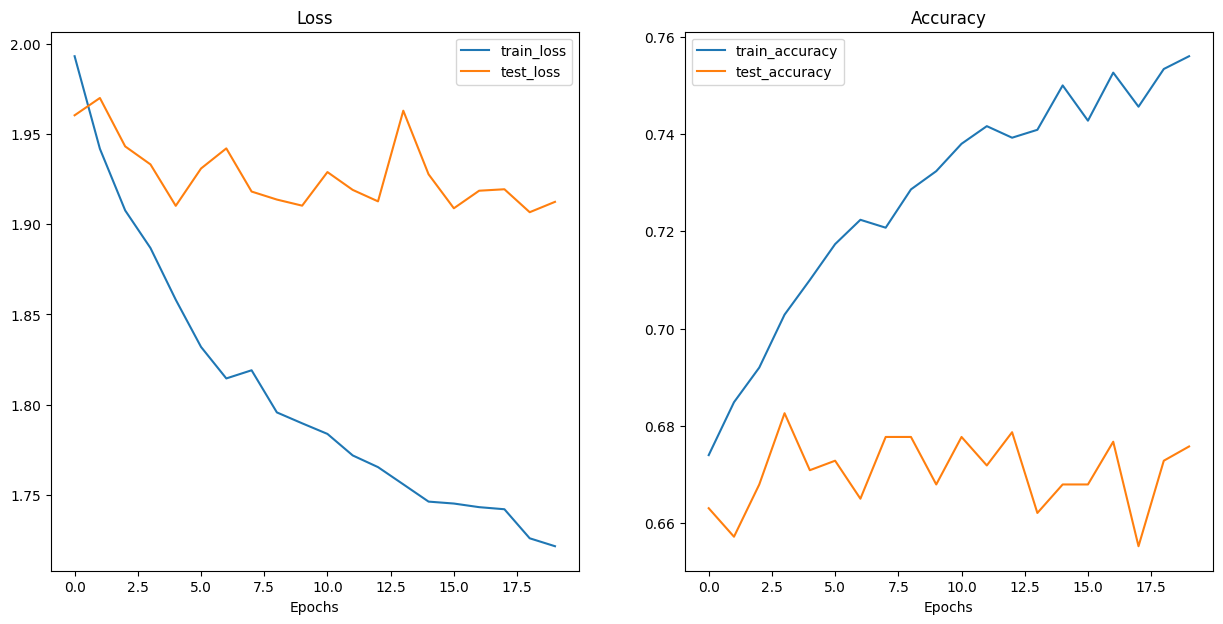

In [67]:
plot_loss_curves(model_results)

Sign of overfitting, but this leaves for future enhancement.

### Saving model

In [68]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name:str):
    
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                          exist_ok=True)
    
    # Create model path
    assert model_name.endswith('.pth') or model_name.endswith('.pt'), 'model_name should be .pt or .pth format.'
    model_save_path = target_dir_path / model_name
    
    # Save the state_dict()
    print(f'[INFO] Saving model to: {model_save_path}')
    torch.save(obj=model.state_dict(),
               f=model_save_path)

In [69]:
model_path = 'fruits_100_feature_extractor_20.pth'

save_model(model=model,
           target_dir='models/',
           model_name=model_path)

[INFO] Saving model to: models\fruits_100_feature_extractor_20.pth


### Loading model

In [70]:
def create_model(num_classes:int):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)
    
    for param in model.parameters():
        param.requires_grad = False
    
    model.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                     nn.Linear(in_features=1408, out_features=num_classes))
    
    return model, transforms

In [72]:
loaded_model, model_transforms = create_model(num_classes=100)

loaded_model.load_state_dict(torch.load('models/fruits_100_feature_extractor_20.pth'))

<All keys matched successfully>

### Check model size

To make sure it works well on portable devices.

In [73]:
model_size = Path('models', model_path).stat().st_size // (1024 * 1024)
print(f'Size of the model (EfficientNetB2): {model_size} MB')

Size of the model (EfficientNetB2): 30 MB


In [74]:
summary(model,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 100]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Turning the model to deployable app

Make the model available for access.

In [77]:
# Fruit 100 app path
fruit_100_path = Path('demos/fruit_100/')

fruit_100_path.mkdir(parents=True,
                     exist_ok=True)

# Make fruit100 example samples
(fruit_100_path / 'examples').mkdir(parents=True, exist_ok=True)

### Exporting Class Names

Export to `class_names.txt` for reusing.

In [79]:
class_names[:10]

['abiu',
 'acai',
 'acerola',
 'ackee',
 'ambarella',
 'apple',
 'apricot',
 'avocado',
 'banana',
 'barbadine']

In [80]:
fruit_100_class_names_path = fruit_100_path / 'class_names.txt'
fruit_100_class_names_path

WindowsPath('demos/fruit_100/class_names.txt')

In [81]:
with open(fruit_100_class_names_path, 'w') as f:
    f.write('\n'.join(class_names))

In [83]:
with open(fruit_100_class_names_path, 'r') as f:
    fruit_100_class_names = [fruit.strip() for fruit in f.readlines()]
    
fruit_100_class_names

['abiu',
 'acai',
 'acerola',
 'ackee',
 'ambarella',
 'apple',
 'apricot',
 'avocado',
 'banana',
 'barbadine',
 'barberry',
 'betel_nut',
 'bitter_gourd',
 'black_berry',
 'black_mullberry',
 'brazil_nut',
 'camu_camu',
 'cashew',
 'cempedak',
 'chenet',
 'cherimoya',
 'chico',
 'chokeberry',
 'cluster_fig',
 'coconut',
 'corn_kernel',
 'cranberry',
 'cupuacu',
 'custard_apple',
 'damson',
 'dewberry',
 'dragonfruit',
 'durian',
 'eggplant',
 'elderberry',
 'emblic',
 'feijoa',
 'fig',
 'finger_lime',
 'gooseberry',
 'goumi',
 'grape',
 'grapefruit',
 'greengage',
 'grenadilla',
 'guava',
 'hard_kiwi',
 'hawthorn',
 'hog_plum',
 'horned_melon',
 'indian_strawberry',
 'jaboticaba',
 'jackfruit',
 'jalapeno',
 'jamaica_cherry',
 'jambul',
 'jocote',
 'jujube',
 'kaffir_lime',
 'kumquat',
 'lablab',
 'langsat',
 'longan',
 'mabolo',
 'malay_apple',
 'mandarine',
 'mango',
 'mangosteen',
 'medlar',
 'mock_strawberry',
 'morinda',
 'mountain_soursop',
 'oil_palm',
 'olive',
 'otaheite_app

### Turning the model into a Python script as `model.py`

In [85]:
%%writefile demos/fruit_100/model.py

import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=100):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)
    
    for param in model.parameters():
        param.requires_grad = False
        
#     torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    
    return model, transforms

Writing demos/fruit_100/model.py


### Turning Fruit 100 app for Gradio to Python Script `app.py`

In [ ]:
%%writefile demos/fruit_100/app.py

import torch
import gradio as gr
import os
from timeit import default_timer as timer
from typing import Tuple, Dict
from model import create_effnetb2_model

# Importing class names
with open('class_names.txt', 'r') as f:
    class_names = [fruit.strip() for fruit in f.readlines()]

# Initialising model
model, model_transforms = create_effnetb2_model(num_classes=len(class_names))

# Load model
model.load_state_dict(torch.load(f='fruits_100_feature_extractor_20.pth'),
                      map_location=torch.device('cpu'))

# Prediction
def predict(img) -> Tuple[Dict, float]:
    # Start a timer
    start_time = timer()
    
    # Transform the input image for use with EffNeetB2
    img = model_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index
    
    # Put model into eval mode, make prediction
    model.eval()
    with torch.inference_mode():
        # Pass transformed image through the model and turn the prediction logits into probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
        
    # Create a prediction label and prediction probability dictionary
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time - start_time, 4)
    
    # Return pred dict and pred time
    return pred_labels_and_probs, pred_time

# Launching demo
# Create title, description, article
title = 'Fruit Vision 👁️🔎🍊'
description = 'Trained 100 Fruit Classes with [EfficientNetB2](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2).'
article = 'Source code at [TC GitHub](https://google.com)'

# Create example list
example_list = [['examples/' + example] for example in os.listdir('examples')]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=5,
                                      label='Predictions'),
                             gr.Number(label='Prediction time (s)')],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo
demo.launch(debug=False, # print error locally
            share=False) # generate a publically shareable URL

### Saving dependencies

In [87]:
%%writefile demos/fruit_100/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==4.0.2

Writing demos/fruit_100/requirements.txt


In [ ]:
###